In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

# --- 1. 플로 시각화 함수 정의 ---
def drawFlow(img, flow, step=16):
    """
    Farneback 옵티컬 플로우 결과를 시각화하는 함수.
    특정 간격(step)마다 화살표를 그려 움직임 벡터를 표시합니다.
    """
    h, w = img.shape[:2]
    # .shape >> (높이, 너비, 채널)
    # .shape[:2] 높이, 너비

    # 16픽셀 간격의 그리드 인덱스 구하기 (좌표: y, x)
    # step//2: 시작 지점을 정수 나눗셈으로 안전하게 지정
    # 시작점: step//2 8, 끝 h (이미지 높이), 간격 (step) 16
    # [ 8, 24, 40, 56 ]
    # y, x를 묶어 (N, 2) 형태의 좌표 목록 (x, y 순서)으로 재구성
    idx_y, idx_x = np.mgrid[step//2:h:step, step//2:w:step].astype(np.int32)
    
    # axis 기본값 0
    # axis=-1 >> 마지막 차원에 추가. (N, 2)
    indices = np.stack((idx_x, idx_y), axis=-1).reshape(-1, 2)

        # x_idx = [10,20,30]
        # y_idx = [20,40,60]

        # np.stack((x_idx, y_idx), axis=0)
        # array([[10, 20, 30],
        #     [20, 40, 60]])

        # np.stack((x_idx, y_idx), axis=1)
        # array([[10, 20],
        #        [20, 40],
        #        [30, 60]])

        # np.stack((x_idx, y_idx), axis=-1)
        # array([[10, 20],
        #        [20, 40],
        #        [30, 60]])

        # np.stack((x_idx, y_idx), axis=-1).shape -> (3,2)
        # -> np.stack((x_idx, y_idx), axis=-1).reshape(-1,2)

    # 화살표 색상 (녹색)
    arrow_color = (0, 255, 0)

    for x, y in indices: # 각 그리드 인덱스 순회 (x: 열, y: 행)
        # 1. 각 그리드 인덱스 위치에 시작점(점) 그리기
        cv2.circle(img, (x, y), 1, arrow_color, -1)

        # 2. 각 그리드 인덱스에 해당하는 플로 결과 값(이동 거리) 얻기
        # flow 배열은 (H, W, 2) 형태이며, (dx, dy) 벡터를 담고 있습니다.
        # dx, dy는 float 형태이므로 정수형으로 변환
        dx, dy = flow[y, x].astype(np.int32)

        # 3. 각 그리드 인덱스 위치에서 이동한 거리만큼 선(화살표) 그리기
        # 시작점: (x, y), 끝점: (x+dx, y+dy)
        end_point = (x + dx, y + dy)
        cv2.arrowedLine(img, (x, y), end_point, arrow_color, 1, cv2.LINE_AA, tipLength=0.3)

prev = None # 이전 프레임 저장 변수

Farneback 광학 흐름 추적 시작 (최대 150 프레임, 20 프레임마다 출력)...

--- Frame 0 Farneback 광학 흐름 결과 ---


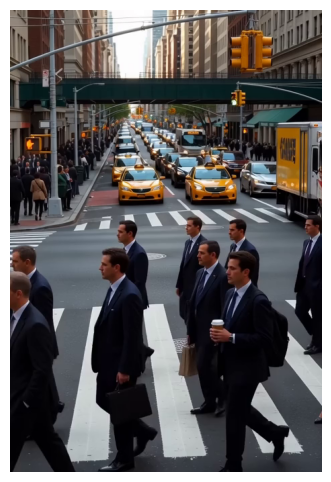


--- Frame 20 Farneback 광학 흐름 결과 ---


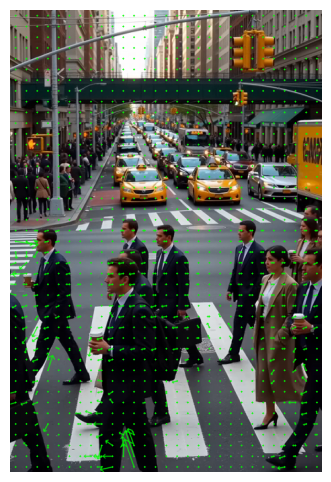


--- Frame 40 Farneback 광학 흐름 결과 ---


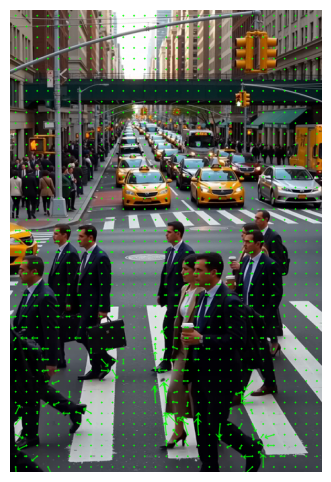


--- Frame 60 Farneback 광학 흐름 결과 ---


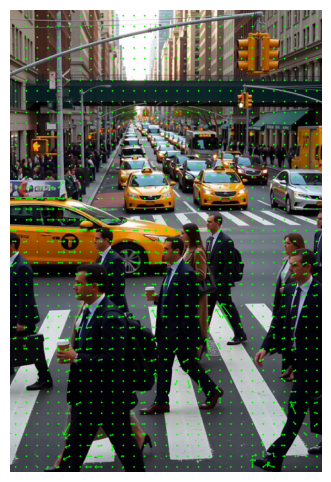


--- Frame 80 Farneback 광학 흐름 결과 ---


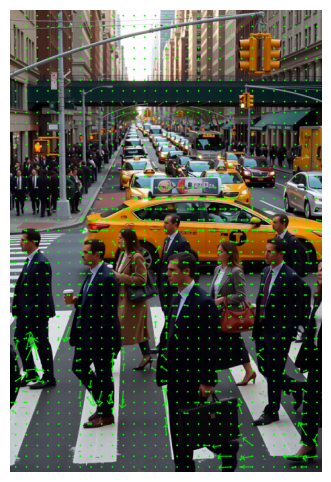


--- Frame 100 Farneback 광학 흐름 결과 ---


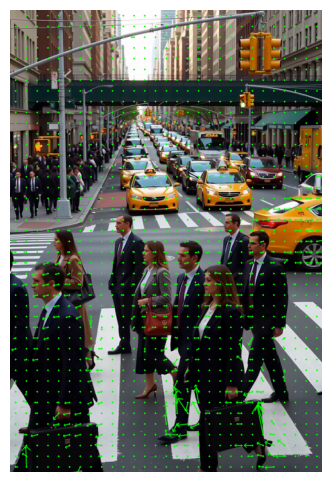


--- Frame 120 Farneback 광학 흐름 결과 ---


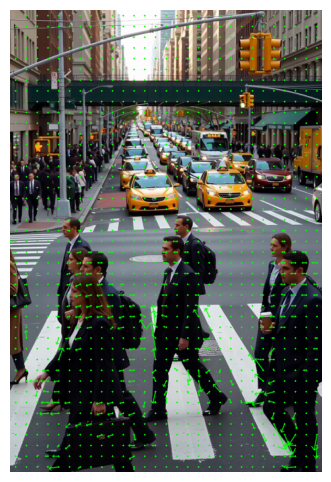


--- Frame 140 Farneback 광학 흐름 결과 ---


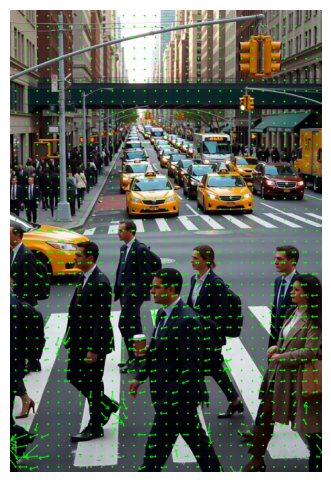

비디오 스트림 종료.

비디오 처리 완료 및 정리.


In [2]:
# --- 2. 비디오 캡처 설정 ---
video_path = 'newyork_grok_251126.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("오류: 비디오 파일을 열 수 없습니다. 파일을 업로드했는지 확인하세요.")
    exit()

frame_count = 0
MAX_FRAMES_TO_PROCESS = 150 # 최대 150 프레임만 처리
DISPLAY_EVERY_N_FRAMES = 20 # 20 프레임마다 결과 출력

print(f"Farneback 광학 흐름 추적 시작 (최대 {MAX_FRAMES_TO_PROCESS} 프레임, {DISPLAY_EVERY_N_FRAMES} 프레임마다 출력)...")

# --- 3. 비디오 처리 루프 ---
while cap.isOpened() and frame_count < MAX_FRAMES_TO_PROCESS:
    ret, frame = cap.read()
    if not ret:
        print("비디오 스트림 종료.")
        break

    # 옵티컬 플로우는 그레이스케일 이미지에서 계산됨
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 최초 프레임의 경우
    if prev is None:
        prev = gray
    else:
        # Farneback 옵티컬 플로우 (Dense Optical Flow) 계산
        flow = cv2.calcOpticalFlowFarneback(prev, gray, None,
                                            0.5, 3, 15, 3, 5, 1.1,
                                            cv2.OPTFLOW_FARNEBACK_GAUSSIAN)

        # 계산된 플로 결과 시각화 함수 호출
        drawFlow(frame, flow)

        # 다음 루프를 위해 현재 프레임을 '이전 프레임'으로 이월
        prev = gray

    # 출력: 특정 간격의 프레임만 표시
    if frame_count % DISPLAY_EVERY_N_FRAMES == 0:
        print(f"\n--- Frame {frame_count} Farneback 광학 흐름 결과 ---")
        
        # OpenCV BGR -> RGB 변환
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Matplotlib을 사용한 이미지 출력
        plt.figure(figsize=(10, 6))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()

    frame_count += 1

# --- 4. 종료 및 정리 ---
print("\n비디오 처리 완료 및 정리.")
cap.release()